In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam

from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

import features
import helpers
import plots
import os

# tf.config.set_visible_devices([], 'GPU') # disable GPU for small models
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
data_folder = 'data/csv/'
data_files = [mice + ".smo.csv" for mice in helpers.mice_breeds["c57bl6"]][:1] # select one mouse
print(f'Using mice: {data_files}')

days_train = [0]
days_test = [1, 2, 3]
window_sizes = [2]#, 5, 10, 20, 50, 100]
window_features = ["EEGv", "EMGv"]
spectral=True
rolloffs = []#[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
useRaw = False
dropBins = False
cat_matrix = True # True for neural net, any for random forest
standardize_df = False
test_size = 0.3

seed = 13

Using mice: ['BL601.smo.csv']


In [3]:
# train and test on same mice
df_train = features.clean_data(
    data_folder=data_folder, 
    data_files=data_files,
    days=days_train, 
    window_sizes=window_sizes, 
    window_features=window_features,
    rolloffs=rolloffs,
    dropBins=dropBins, 
    useRaw=useRaw, 
    balance=True, 
    standardize_df=standardize_df
)

df_test = features.clean_data(
    data_folder=data_folder, 
    data_files=data_files,
    days=days_test, 
    window_sizes=window_sizes, 
    window_features=window_features,
    rolloffs=rolloffs,
    dropBins=dropBins, 
    useRaw=useRaw, 
    balance=True, 
    standardize_df=standardize_df
)

x_train, x_test, y_train, y_test, le = features.encode_scale_data(df_train, df_test, useRaw, seed, cat_matrix)

# Neural Network

In [4]:
def baseline_model(input_dim, num_classes, lr):
    model = Sequential()
    model.add(Dense(3, input_dim=input_dim, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

    return model

model = baseline_model(x_train.shape[1], le.classes_.size, lr=1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 1239      
                                                                 
 dense_1 (Dense)             (None, 3)                 12        
                                                                 
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

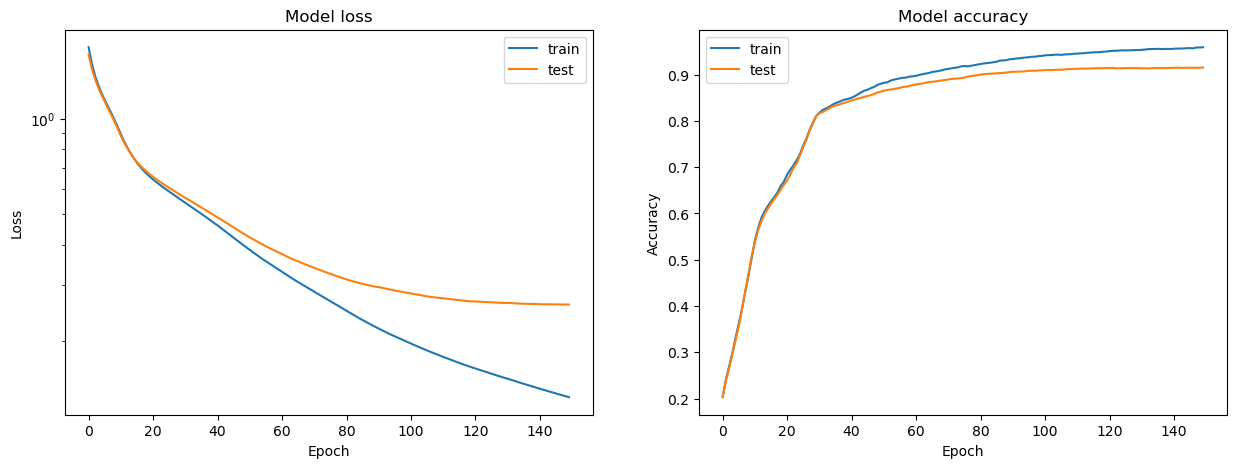

In [5]:
model = baseline_model(x_train.shape[1], le.classes_.size, lr=1e-4)
history = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_test, y_test),
                    epochs=150,
                    batch_size=64,
                    verbose=0,
                    callbacks=[TqdmCallback(verbose=1)]
                )

plots.plot_history(history.history)

302/302 [==============================] - 0s 625us/step
[[2953  120  142]
 [ 127 2941  147]
 [ 137  146 2932]]
              precision    recall  f1-score   support

           n       0.92      0.92      0.92      3215
           r       0.92      0.91      0.92      3215
           w       0.91      0.91      0.91      3215

    accuracy                           0.92      9645
   macro avg       0.92      0.92      0.92      9645
weighted avg       0.92      0.92      0.92      9645



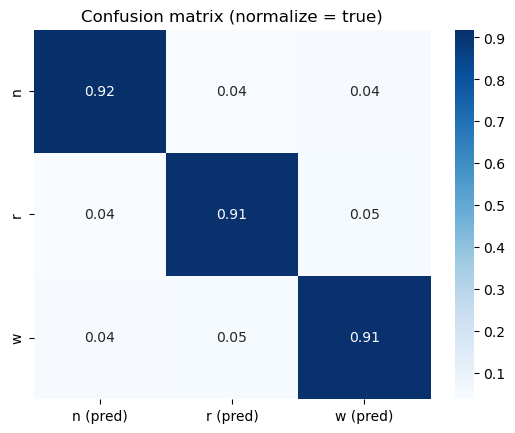

In [6]:
plots.plot_confusion(model=model, x_test=x_test, y_test=y_test, le=le, cat_matrix=True, normalize='true')

# K-Fold Cross Validation

In [7]:
#from sklearn.model_selection import KFold
#
#x, y, le = features.split_encode_scale_data_kfold(df, useRaw, seed, cat_matrix=True)
#model = baseline_model(x_train.shape[1], le.classes_.size)
#
#kfold = KFold(n_splits=5, shuffle=True)
#
## K-fold Cross Validation model evaluation
#fold_no = 1
#for train, test in kfold.split(x, y):
#  model = baseline_model(x_train.shape[1], le.classes_.size)
#  # Generate a print
#  print(f'Training for fold {fold_no} ...')
#
#  # Fit data to model
#  history = model.fit(x=x[train],
#                    y=y[train],
#                    epochs=300,
#                    batch_size=64,
#                    verbose=0,
#                )
#
#  # confusion matrix
#  cm = np.zeros((le.classes_.size, le.classes_.size))
#  cm = cm + plots.confusion(model=model, x_test=x[test], y_test=y[test], le=le, cat_matrix=True)
#  # Increase fold number
#  fold_no = fold_no + 1
#
#confusion = pd.DataFrame(cm, index=le.classes_, columns=le.classes_ + ' (pred)')
#sns.heatmap(confusion, annot=True, cmap="Blues", fmt='.2f')
#plt.title(f'Confusion matrix (normalize = true')
#plt.show()

# Random Forest

In [8]:
#rfc = RandomForestClassifier(random_state=seed)
#rfc.fit(x_train, y_train)
#y_predict = rfc.predict(x_test)

#plots.plot_confusion(model=rfc, x_test=x_test, y_test=y_test, le=le, cat_matrix=cat_matrix, normalize='true')